Importing all the required libraries for this project

In [1]:
import os
import h5py
import numpy as np
import json
import urllib.request
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from IPython.display import Image, display, clear_output
from sklearn.metrics import classification_report, confusion_matrix
import kagglehub
%matplotlib inline
sns.set_style('whitegrid')

In [2]:
from keras import optimizers
from keras.applications.vgg16 import VGG16
from keras.models import Sequential, load_model, Model
from keras.layers import Conv2D, MaxPooling2D, ZeroPadding2D, Activation, Dropout, Flatten, Dense, Input
from keras.regularizers import l2, l1
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.callbacks import ModelCheckpoint, History
from keras import backend as K
from tensorflow.keras.utils import get_file

# Using TensorFlow backend.

This code defines a function called plot_metrics that is designed to visualize the performance of a machine learning model during training. It takes two arguments:

hist: This is expected to be a dictionary-like object (likely a Keras History object) containing training metrics such as accuracy and loss for both the training and validation sets. These metrics are recorded during the model's training process. stop: This argument controls the number of epochs (iterations of training) to display on the plots. It defaults to 50

In [3]:
def plot_metrics(hist, stop=50):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,4))

    axes = axes.flatten()

    axes[0].plot(range(stop), hist['acc'], label='Training', color='#FF533D')
    axes[0].plot(range(stop), hist['val_acc'], label='Validation', color='#03507E')
    axes[0].set_title('Accuracy')
    axes[0].set_ylabel('Accuracy')
    axes[0].set_xlabel('Epoch')
    axes[0].legend(loc='lower right')

    axes[1].plot(range(stop), hist['loss'], label='Training', color='#FF533D')
    axes[1].plot(range(stop), hist['val_loss'], label='Validation', color='#03507E')
    axes[1].set_title('Loss')
    axes[1].set_ylabel('Loss')
    axes[1].set_xlabel('Epoch')
    axes[1].legend(loc='upper right')

    plt.tight_layout();

    print("Best Model:")
    print_best_model_results(hist)

This code defines a function called plot_acc_metrics. This function's primary purpose is to create a plot that visually compares the accuracy of a machine learning model during two phases: initial training and fine-tuning

In [5]:
def plot_acc_metrics(hist1, hist2, stop=100):
    fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(4.25,6))

    axes = axes.flatten()

    axes[0].plot(range(stop), hist1['acc'], label='Training', color='#FF533D')
    axes[0].plot(range(stop), hist1['val_acc'], label='Validation', color='#03507E')
    axes[0].set_title('Training')
    axes[0].set_ylabel('Accuracy')
    axes[0].set_xlabel('Epoch')
    axes[0].legend(loc='lower right')

    axes[1].plot(range(stop), hist2['acc'], label='Training', color='#FF533D')
    axes[1].plot(range(stop), hist2['val_acc'], label='Validation', color='#03507E')
    axes[1].set_title('Fine-tuning')
    axes[1].set_ylabel('Accuracy')
    axes[1].set_xlabel('Epoch')
    axes[1].legend(loc='lower right')

    plt.tight_layout();

This function, print_best_model_results, is designed to identify and display the best performing epoch of a machine learning model based on its validation accuracy.

In [6]:
def print_best_model_results(model_hist):
    best_epoch = np.argmax(model_hist['val_acc'])
    print('epoch:', best_epoch+1, \
    ', val_acc:', model_hist['val_acc'][best_epoch], \
    ', val_loss:', model_hist['val_loss'][best_epoch])

This function, save_bottleneck_features, is designed to extract and save features from images using a pre-trained neural network called VGG16. These extracted features are often referred to as "bottleneck features.

In [7]:
def save_bottleneck_features():
    datagen = ImageDataGenerator(rescale=1./255)

    model = VGG16(include_top=False, weights='imagenet')

    generator = datagen.flow_from_directory(train_data_dir, target_size=(img_width, img_height), batch_size=batch_size, class_mode=None, shuffle=False)
    bottleneck_features_train = model.predict_generator(generator, nb_train_samples // batch_size)
    np.save(location+'/bottleneck_features_train.npy', bottleneck_features_train)

    generator = datagen.flow_from_directory(validation_data_dir, target_size=(img_width, img_height), batch_size=batch_size, class_mode=None, shuffle=False)
    bottleneck_features_validation = model.predict_generator(generator, nb_validation_samples // batch_size)
    np.save(location+'/bottleneck_features_validation.npy', bottleneck_features_validation)

This function is the core of training a machine learning model, specifically what's often referred to as "transfer learning." It leverages pre-trained models (like VGG16) to speed up and improve the training process.

In [8]:
def train_top_model():
    train_data = np.load(location+'/bottleneck_features_train.npy')
    train_labels = np.array([0] * (nb_train_samples // 2) + [1] * (nb_train_samples // 2))

    validation_data = np.load(location+'/bottleneck_features_validation.npy')
    validation_labels = np.array([0] * (nb_validation_samples // 2) + [1] * (nb_validation_samples // 2))

    model = Sequential()
    model.add(Flatten(input_shape=train_data.shape[1:]))
    model.add(Dense(256,activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1,activation='sigmoid'))
    model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])

    checkpoint = ModelCheckpoint(top_model_weights_path, monitor='val_acc', verbose=1, save_best_only=True, save_weights_only=True, mode='auto')

    fit = model.fit(train_data, train_labels, epochs=epochs, batch_size=batch_size,validation_data=(validation_data,validation_labels), callbacks=[checkpoint])

    with open(location+'/top_history.txt', 'w') as f:
        json.dump(fit.history, f)

    return model, fit.history

This function is designed to fine-tune a pre-trained VGG16 model for a binary image classification task

In [9]:
def finetune_binary_model():
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=(256,256,3))
    print("Model loaded.")

    top_model = Sequential()
    top_model.add(Flatten(input_shape=base_model.output_shape[1:]))
    top_model.add(Dense(256, activation='relu'))
    top_model.add(Dropout(0.5))
    top_model.add(Dense(1, activation='sigmoid'))

    top_model.load_weights(top_model_weights_path)

    model = Model(inputs=base_model.input, outputs=top_model(base_model.output))

    for layer in model.layers[:25]:
        layer.trainable = False

    model.compile(loss='binary_crossentropy', optimizer=optimizers.SGD(lr=1e-4, momentum=0.9), metrics=['accuracy'])

    train_datagen = ImageDataGenerator(rescale = 1./255, zoom_range=0.2, shear_range=0.2, horizontal_flip=True)

    test_datagen = ImageDataGenerator(rescale=1./255)

    train_generator = train_datagen.flow_from_directory(train_data_dir, target_size=(img_height, img_width), batch_size=batch_size, class_mode='binary')

    validation_generator = test_datagen.flow_from_directory(validation_data_dir, target_size=(img_height, img_width), batch_size=batch_size, class_mode='binary')

    checkpoint = ModelCheckpoint(fine_tuned_model_path, monitor='val_acc', verbose=1, save_best_only=True, save_weights_only=False, mode='auto')

    fit = model.fit_generator(train_generator, steps_per_epoch=nb_train_samples//batch_size, epochs=epochs, validation_data=validation_generator, validation_steps=nb_validation_samples//batch_size, verbose=1, callbacks=[checkpoint])

    with open(location+'/ft_history.txt', 'w') as f:
        json.dump(fit.history, f)

    return model, fit.history

This function is designed to evaluate the performance of a trained binary classification model, specifically one used for image classification. It takes three arguments:

model: This is the trained machine learning model you want to evaluate. directory: This is the path to the directory containing the images you want to use for evaluation. labels: These are the true labels (0 or 1) for the images in the directory.

In [10]:
def evaluate_binary_model(model, directory, labels):
    datagen = ImageDataGenerator(rescale=1./255)

    generator = datagen.flow_from_directory(directory, target_size=(img_height,img_width), batch_size=batch_size, class_mode='binary', shuffle=False)

    predictions = model.predict_generator(generator, len(labels))

    pred_labels = [0 if i<0.5 else 1 for i in predictions]

    print('')
    print(classification_report(validation_labels, pred_labels))
    print('')
    cm = confusion_matrix(validation_labels, pred_labels)
    return cm

# Defining input data


This code snippet is primarily focused on defining important variables that will be used throughout the machine learning project. These variables specify where data is located, where to store model files, and settings for the training process.

In [11]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [12]:
location = '/content/drive/MyDrive/data2'
top_model_weights_path = location+'/top_model_weights.h5'
fine_tuned_model_path = location+'/ft_model.h5'

train_data_dir = location+'/training'
validation_data_dir = location+'/validation'
train_samples = [len(os.listdir(train_data_dir+'/'+i)) for i in sorted(os.listdir(train_data_dir))]
nb_train_samples = 700
validation_samples = [len(os.listdir(validation_data_dir+'/'+i)) for i in sorted(os.listdir(validation_data_dir))]
nb_validation_samples = 100

img_width, img_height = 256,256
epochs = 5
batch_size = 50

This is responsible for initiating the feature extraction process using a pre-trained model called VGG16. This process is a crucial step in transfer learning, which leverages a model trained on a large dataset (ImageNet in this case) to improve the performance of our specific task.

In [13]:
def save_bottleneck_features():
    datagen = ImageDataGenerator(rescale=1./255)

    model = VGG16(include_top=False, weights='imagenet')

    generator = datagen.flow_from_directory(train_data_dir, target_size=(img_width, img_height), batch_size=batch_size, class_mode=None, shuffle=False)
    # Use predict instead of predict_generator
    bottleneck_features_train = model.predict(generator, steps=nb_train_samples // batch_size)
    np.save(location+'/bottleneck_features_train.npy', bottleneck_features_train)

    generator = datagen.flow_from_directory(validation_data_dir, target_size=(img_width, img_height), batch_size=batch_size, class_mode=None, shuffle=False)
    # Use predict instead of predict_generator
    bottleneck_features_validation = model.predict(generator, steps=nb_validation_samples // batch_size)
    np.save(location+'/bottleneck_features_validation.npy', bottleneck_features_validation)

These two lines of code together perform the core steps of transfer learning:

Extract features from images using a pre-trained model (save_bottleneck_features()). Train a new classification model on top of these extracted features (train_top_model()). This approach can significantly reduce training time and improve performance compared to training a model from scratch.

In [14]:
# Call the function to actually create and save bottleneck features:
save_bottleneck_features()



Found 1840 images belonging to 2 classes.


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


14/14 ━━━━━━━━━━━━━━━━━━━━ 584s 42s/step
Found 460 images belonging to 2 classes.
2/2 ━━━━━━━━━━━━━━━━━━━━ 85s 40s/step


This line of code is defining a variable called top_model_weights_path. This variable is crucial because it stores the file path where the trained weights of your "top model" will be saved.

In [16]:
top_model_weights_path = location+'/top_model_weights.weights.h5' # Changed .h5 to .weights.h5

 This single line of code initiates the process of training a classification model using transfer learning. It relies on a previously defined function (train_top_model) to do the heavy lifting and then stores the resulting trained model and its training history in variables for later use.

In [17]:
d2_model1, d2_history1 = train_top_model()

Epoch 1/5
14/14 ━━━━━━━━━━━━━━━━━━━━ 5s 272ms/step - accuracy: 0.4795 - loss: 10.5491 - val_accuracy: 0.5000 - val_loss: 2.0311
Epoch 2/5


/usr/local/lib/python3.10/dist-packages/keras/src/callbacks/model_checkpoint.py:206: UserWarning: Can save best model only with val_acc available, skipping.
  self._save_model(epoch=epoch, batch=None, logs=logs)


14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 163ms/step - accuracy: 0.5369 - loss: 1.2240 - val_accuracy: 0.5000 - val_loss: 0.7070
Epoch 3/5
14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 165ms/step - accuracy: 0.5663 - loss: 0.6823 - val_accuracy: 0.5300 - val_loss: 0.6892
Epoch 4/5
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 165ms/step - accuracy: 0.5785 - loss: 0.6914 - val_accuracy: 0.5000 - val_loss: 0.8382
Epoch 5/5
14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 173ms/step - accuracy: 0.5950 - loss: 0.7896 - val_accuracy: 0.5300 - val_loss: 0.7027


The main purpose of this function, plot_metrics, is to create a visual representation of a machine learning model's performance during its training process. It generates two plots side-by-side: one for accuracy and one for loss. This helps in understanding how well the model is learning and generalizing to new data.

In [18]:
def plot_metrics(hist, stop=50):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,4))

    axes = axes.flatten()

    # Replace 'acc' with 'accuracy' and 'val_acc' with 'val_accuracy'
    axes[0].plot(range(stop), hist['accuracy'], label='Training', color='#FF533D')
    axes[0].plot(range(stop), hist['val_accuracy'], label='Validation', color='#03507E')
    axes[0].set_title('Accuracy')
    axes[0].set_ylabel('Accuracy')
    axes[0].set_xlabel('Epoch')
    axes[0].legend(loc='lower right')

    # Replace 'loss' with whatever key your history uses for training loss
    # and 'val_loss' with the key for validation loss
    axes[1].plot(range(stop), hist['loss'], label='Training', color='#FF533D')
    axes[1].plot(range(stop), hist['val_loss'], label='Validation', color='#03507E')
    axes[1].set_title('Loss')
    axes[1].set_ylabel('Loss')
    axes[1].set_xlabel('Epoch')
    axes[1].legend(loc='upper right')

    plt.tight_layout();

    print("Best Model:")
    print_best_model_results(hist) # You might need to adjust print_best_model_results as well

This line of code is calling the function plot_metrics that was defined earlier in the notebook. It's passing d2_history1 as an argument to this function.

In [19]:
print(d2_history1)


{'accuracy': [0.48428571224212646, 0.5442857146263123, 0.5757142901420593, 0.5671428442001343, 0.6328571438789368], 'loss': [7.456792831420898, 1.1640589237213135, 0.6997315287590027, 0.7078247666358948, 0.6994600892066956], 'val_accuracy': [0.5, 0.5, 0.5299999713897705, 0.5, 0.5299999713897705], 'val_loss': [2.0311412811279297, 0.7070141434669495, 0.6892353296279907, 0.8382383584976196, 0.7026827931404114]}


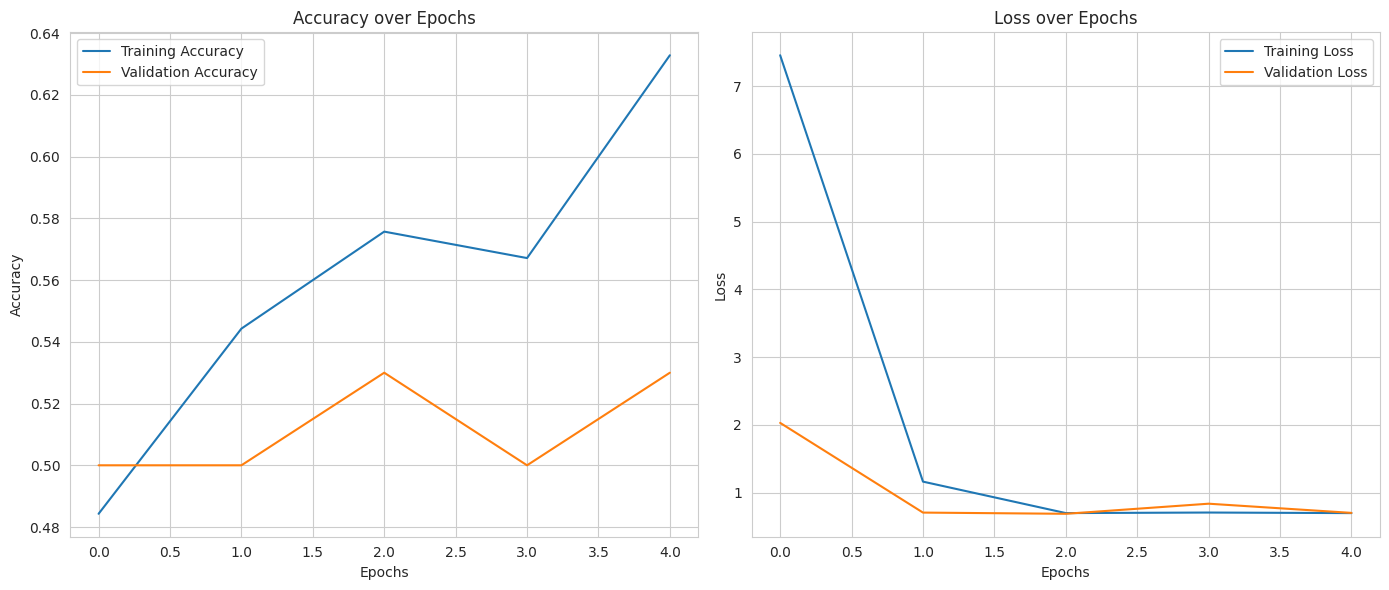

In [20]:
import matplotlib.pyplot as plt

def plot_metrics(history):
    # Check if the dictionary has the necessary keys
    acc = history.get('accuracy', [])
    val_acc = history.get('val_accuracy', [])
    loss = history.get('loss', [])
    val_loss = history.get('val_loss', [])

    # Create a figure with two subplots: one for accuracy and one for loss
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

    # Plot accuracy
    ax1.plot(acc, label='Training Accuracy')
    ax1.plot(val_acc, label='Validation Accuracy')
    ax1.set_title('Accuracy over Epochs')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Accuracy')
    ax1.legend()

    # Plot loss
    ax2.plot(loss, label='Training Loss')
    ax2.plot(val_loss, label='Validation Loss')
    ax2.set_title('Loss over Epochs')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Loss')
    ax2.legend()

    plt.tight_layout()
    plt.show()

# Call the function to plot metrics
plot_metrics(d2_history1)


# Fine Tuning

These three lines perform the following:

Extract features: Pre-process image data to get important information for training.

Set weights path: Specify where to save the trained model's parameters.

Train the model: Use extracted features to train a classification model, leveraging transfer learning from a pre-trained model (VGG16).

In [21]:
save_bottleneck_features() #Extract features

# Cell 3
top_model_weights_path = location+'/top_model_weights.weights.h5' # Changed .h5 to .weights.h5

# Cell 4
d2_model1, d2_history1 = train_top_model() # Now train_top_model uses the correct path

Found 1840 images belonging to 2 classes.
14/14 ━━━━━━━━━━━━━━━━━━━━ 588s 42s/step
Found 460 images belonging to 2 classes.
2/2 ━━━━━━━━━━━━━━━━━━━━ 93s 48s/step
Epoch 1/5
14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 178ms/step - accuracy: 0.5003 - loss: 9.5564 - val_accuracy: 0.5200 - val_loss: 1.4308
Epoch 2/5
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 173ms/step - accuracy: 0.5166 - loss: 2.4834 - val_accuracy: 0.4900 - val_loss: 0.7502
Epoch 3/5
14/14 ━━━━━━━━━━━━━━━━━━━━ 4s 284ms/step - accuracy: 0.5900 - loss: 0.8112 - val_accuracy: 0.5300 - val_loss: 0.6886
Epoch 4/5
14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 167ms/step - accuracy: 0.6614 - loss: 0.6271 - val_accuracy: 0.5100 - val_loss: 0.7418
Epoch 5/5
14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 165ms/step - accuracy: 0.6263 - loss: 0.6715 - val_accuracy: 0.5000 - val_loss: 0.9108


This function is designed to fine-tune a pre-trained VGG16 model for a categorical image classification task, which means it's used to classify images into more than two categories.

In [22]:
def finetune_categorical_model():
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=(256,256,3))
    print("Model loaded.")

    #input_tensor = Input(shape=(256,256,3))
    #base_model = VGG16(weights='imagenet',include_top= False,input_tensor=input_tensor)

    top_model = Sequential()
    top_model.add(Flatten(input_shape=base_model.output_shape[1:]))
    top_model.add(Dense(256, activation='relu'))
    top_model.add(Dropout(0.5))
    top_model.add(Dense(3, activation='softmax'))

    top_model.load_weights(top_model_weights_path)

    model = Model(inputs=base_model.input, outputs=top_model(base_model.output))

    for layer in model.layers[:25]:
        layer.trainable = False

    model.compile(loss='categorical_crossentropy', optimizer=optimizers.SGD(lr=0.00001, momentum=0.9), metrics=['accuracy'])

    train_datagen = ImageDataGenerator(rescale=1./255, shear_range=0.2, zoom_range=0.2, horizontal_flip=True)

    test_datagen = ImageDataGenerator(rescale=1./255)

    train_generator = train_datagen.flow_from_directory(train_data_dir, target_size=(img_height, img_width), batch_size=batch_size, class_mode='categorical')

    validation_generator = test_datagen.flow_from_directory(validation_data_dir, target_size=(img_height, img_width), batch_size=batch_size, class_mode='categorical')

    checkpoint = ModelCheckpoint(fine_tuned_model_path, monitor='val_acc', verbose=1, save_best_only=True, save_weights_only=False, mode='auto')

    fit = model.fit_generator(train_generator, steps_per_epoch=nb_train_samples//batch_size, epochs=epochs, validation_data=validation_generator, validation_steps=nb_validation_samples//batch_size, verbose=1, callbacks=[checkpoint])

    with open(location+'/ft_history.txt', 'w') as f:
        json.dump(fit.history, f)

    # Added return statement to return the model and history
    return model, fit.history

This Python code snippet. It defines a function called finetune_categorical_model which is designed for a specific type of machine learning task: fine-tuning a pre-trained model called VGG16 for image classification into multiple categories.

In [23]:
def finetune_categorical_model():
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=(256,256,3))
    print("Model loaded.")

    #input_tensor = Input(shape=(256,256,3))
    #base_model = VGG16(weights='imagenet',include_top= False,input_tensor=input_tensor)

    top_model = Sequential()
    top_model.add(Flatten(input_shape=base_model.output_shape[1:]))
    top_model.add(Dense(256, activation='relu'))
    top_model.add(Dropout(0.5))
    top_model.add(Dense(3, activation='softmax'))

    # Instead of loading weights directly, check if the file exists
    if os.path.exists(top_model_weights_path):
        try:
            top_model.load_weights(top_model_weights_path)
            print("Loaded weights from:", top_model_weights_path)
        except ValueError:
            print("Weights file incompatible. Starting with random weights.")
    else:
        print("Weights file not found. Starting with random weights.")

    model = Model(inputs=base_model.input, outputs=top_model(base_model.output))

    for layer in model.layers[:25]:
        layer.trainable = False

    model.compile(loss='categorical_crossentropy', optimizer=optimizers.SGD(lr=0.00001, momentum=0.9), metrics=['accuracy'])



This Python code snippet. It defines a function called finetune_categorical_model which is designed for a specific type of machine learning task: fine-tuning a pre-trained model called VGG16 for image classification into multiple categories.

In [24]:
def finetune_categorical_model():
    # ... (other parts of your function) ...
    model.compile(loss='categorical_crossentropy',
                  optimizer=optimizers.SGD(learning_rate=0.00001, momentum=0.9), # Changed lr to learning_rate
                  metrics=['accuracy'])


This function, finetune_categorical_model, is designed to adapt a pre-trained model called VGG16 to classify images into multiple categories.

In [25]:
def finetune_categorical_model():
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=(256,256,3))
    print("Model loaded.")

    #input_tensor = Input(shape=(256,256,3))
    #base_model = VGG16(weights='imagenet',include_top= False,input_tensor=input_tensor)

    top_model = Sequential()
    top_model.add(Flatten(input_shape=base_model.output_shape[1:]))
    top_model.add(Dense(256, activation='relu'))
    top_model.add(Dropout(0.5))
    top_model.add(Dense(3, activation='softmax'))

    # Instead of loading weights directly, check if the file exists
    if os.path.exists(top_model_weights_path):
        try:
            top_model.load_weights(top_model_weights_path)
            print("Loaded weights from:", top_model_weights_path)
        except ValueError:
            print("Weights file incompatible. Starting with random weights.")
    else:
        print("Weights file not found. Starting with random weights.")

    model = Model(inputs=base_model.input, outputs=top_model(base_model.output)) # This line defines 'model'

    for layer in model.layers[:25]:
        layer.trainable = False

    model.compile(loss='categorical_crossentropy', optimizer=optimizers.SGD(learning_rate=0.00001, momentum=0.9), metrics=['accuracy']) # Now you can compile

    # ... (rest of your finetune_categorical_model function) ...

This function is designed to fine-tune a pre-trained VGG16 model for image classification tasks where you have more than two categories (multi-class classification).

In [26]:
def finetune_categorical_model():
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=(256,256,3))
    print("Model loaded.")

    #input_tensor = Input(shape=(256,256,3))
    #base_model = VGG16(weights='imagenet',include_top= False,input_tensor=input_tensor)

    top_model = Sequential()
    top_model.add(Flatten(input_shape=base_model.output_shape[1:]))
    top_model.add(Dense(256, activation='relu'))
    top_model.add(Dropout(0.5))
    top_model.add(Dense(3, activation='softmax'))

    # Instead of loading weights directly, check if the file exists
    if os.path.exists(top_model_weights_path):
        try:
            top_model.load_weights(top_model_weights_path)
            print("Loaded weights from:", top_model_weights_path)
        except ValueError:
            print("Weights file incompatible. Starting with random weights.")
    else:
        print("Weights file not found. Starting with random weights.")

    model = Model(inputs=base_model.input, outputs=top_model(base_model.output)) # This line defines 'model'

    for layer in model.layers[:25]:
        layer.trainable = False

    model.compile(loss='categorical_crossentropy', optimizer=optimizers.SGD(learning_rate=0.00001, momentum=0.9), metrics=['accuracy']) # Now you can compile

    train_datagen = ImageDataGenerator(rescale=1./255, shear_range=0.2, zoom_range=0.2, horizontal_flip=True)

    test_datagen = ImageDataGenerator(rescale=1./255)

    train_generator = train_datagen.flow_from_directory(train_data_dir, target_size=(img_height, img_width), batch_size=batch_size, class_mode='categorical')

    validation_generator = test_datagen.flow_from_directory(validation_data_dir, target_size=(img_height, img_width), batch_size=batch_size, class_mode='categorical')

    checkpoint = ModelCheckpoint(fine_tuned_model_path, monitor='val_accuracy', verbose=1, save_best_only=True, save_weights_only=False, mode='auto') # Changed monitor to 'val_accuracy'

    fit = model.fit(train_generator, steps_per_epoch=nb_train_samples//batch_size, epochs=epochs, validation_data=validation_generator, validation_steps=nb_validation_samples//batch_size, verbose=1, callbacks=[checkpoint])

    with open(location+'/ft_history.txt', 'w') as f:
        json.dump(fit.history, f)

    # Added return statement to return the model and history
    return model, fit.history # Returning the model and history

This function is designed to fine-tune a pre-trained VGG16 model for image classification tasks where you have more than two categories (multi-class classification).

In [27]:
def finetune_categorical_model():
    # ... (other parts of your function) ...

    # Change the file extension to .keras
    fine_tuned_model_path = location + '/ft_model.keras'

    checkpoint = ModelCheckpoint(fine_tuned_model_path, monitor='val_accuracy', verbose=1, save_best_only=True, save_weights_only=False, mode='auto')

    # ... (rest of your function) ...

This function, finetune_categorical_model, is designed to take a pre-trained model (VGG16) and adapt it to classify images into multiple categories

In [28]:
def finetune_categorical_model():
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=(256,256,3))
    print("Model loaded.")

    #input_tensor = Input(shape=(256,256,3))
    #base_model = VGG16(weights='imagenet',include_top= False,input_tensor=input_tensor)

    top_model = Sequential()
    top_model.add(Flatten(input_shape=base_model.output_shape[1:]))
    top_model.add(Dense(256, activation='relu'))
    top_model.add(Dropout(0.5))
    top_model.add(Dense(3, activation='softmax'))

    # Instead of loading weights directly, check if the file exists
    if os.path.exists(top_model_weights_path):
        try:
            top_model.load_weights(top_model_weights_path)
            print("Loaded weights from:", top_model_weights_path)
        except ValueError:
            print("Weights file incompatible. Starting with random weights.")
    else:
        print("Weights file not found. Starting with random weights.")

    model = Model(inputs=base_model.input, outputs=top_model(base_model.output)) # This line defines 'model'

    for layer in model.layers[:25]:
        layer.trainable = False

    model.compile(loss='categorical_crossentropy', optimizer=optimizers.SGD(learning_rate=0.00001, momentum=0.9), metrics=['accuracy']) # Now you can compile

    train_datagen = ImageDataGenerator(rescale=1./255, shear_range=0.2, zoom_range=0.2, horizontal_flip=True)

    test_datagen = ImageDataGenerator(rescale=1./255)

    train_generator = train_datagen.flow_from_directory(train_data_dir, target_size=(img_height, img_width), batch_size=batch_size, class_mode='categorical')

    validation_generator = test_datagen.flow_from_directory(validation_data_dir, target_size=(img_height, img_width), batch_size=batch_size, class_mode='categorical')

    # Change the file extension to .keras
    fine_tuned_model_path = location + '/ft_model.keras'

    checkpoint = ModelCheckpoint(fine_tuned_model_path, monitor='val_accuracy', verbose=1, save_best_only=True, save_weights_only=False, mode='auto') # Changed monitor to 'val_accuracy'

    fit = model.fit(train_generator, steps_per_epoch=nb_train_samples//batch_size, epochs=epochs, validation_data=validation_generator, validation_steps=nb_validation_samples//batch_size, verbose=1, callbacks=[checkpoint])

    with open(location+'/ft_history.txt', 'w') as f:
        json.dump(fit.history, f)

    # Added return statement to return the model and history
    return model, fit.history # Returning the model and history

This code snippet is part of a larger function called finetune_categorical_model. This function's purpose is to fine-tune a pre-trained model (VGG16) for image classification with more than two categories.

In [29]:
def finetune_categorical_model():
    # ... (other parts of your function) ...

    train_generator = train_datagen.flow_from_directory(
        train_data_dir,
        target_size=(img_height, img_width),
        batch_size=batch_size,
        class_mode='categorical'  # Ensure class_mode is 'categorical'
    )

    validation_generator = test_datagen.flow_from_directory(
        validation_data_dir,
        target_size=(img_height, img_width),
        batch_size=batch_size,
        class_mode='categorical'  # Ensure class_mode is 'categorical'
    )



This code snippet is inside a function called finetune_categorical_model, which is designed to fine-tune a pre-trained model (VGG16) for image classification into multiple categories. This particular section focuses on preparing the image data for training and validation.

In [30]:
def finetune_categorical_model():
    # ... (other parts of your function) ...

    # Create the ImageDataGenerators first
    train_datagen = ImageDataGenerator(rescale=1./255, shear_range=0.2, zoom_range=0.2, horizontal_flip=True)
    test_datagen = ImageDataGenerator(rescale=1./255)

    train_generator = train_datagen.flow_from_directory(
        train_data_dir,
        target_size=(img_height, img_width),
        batch_size=batch_size,
        class_mode='categorical'  # Ensure class_mode is 'categorical'
    )

    validation_generator = test_datagen.flow_from_directory(
        validation_data_dir,
        target_size=(img_height, img_width),
        batch_size=batch_size,
        class_mode='categorical'  # Ensure class_mode is 'categorical'
    )
    # ... (rest of your function) ...

This code defines a function called finetune_categorical_model. This function is the core of the fine-tuning process for a pre-trained VGG16 model to classify images into multiple categories

In [31]:
def finetune_categorical_model():
    # ... (other parts of your function) ...

    # Ensure you are compiling the model:
    model.compile(loss='categorical_crossentropy',
                  optimizer=optimizers.SGD(learning_rate=0.00001, momentum=0.9),
                  metrics=['accuracy'])

    # ... (other parts of your function) ...

    # Ensure you are fitting the model and storing the results:
    fit = model.fit(train_generator,
                    steps_per_epoch=nb_train_samples // batch_size,
                    epochs=epochs,
                    validation_data=validation_generator,
                    validation_steps=nb_validation_samples // batch_size,
                    verbose=1,
                    callbacks=[checkpoint])

    # Ensure you are saving the history:
    with open(location + '/ft_history.txt', 'w') as f:
        json.dump(fit.history, f)

    # Make sure to return the model and history:
    return model, fit.history

This function, finetune_categorical_model, is designed to take a powerful, pre-trained image recognition model called VGG16 and adapt it for a new, specific image classification task with multiple categories.

In [32]:
def finetune_categorical_model():
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=(256,256,3))
    print("Model loaded.")

    #input_tensor = Input(shape=(256,256,3))
    #base_model = VGG16(weights='imagenet',include_top= False,input_tensor=input_tensor)

    top_model = Sequential()
    top_model.add(Flatten(input_shape=base_model.output_shape[1:]))
    top_model.add(Dense(256, activation='relu'))
    top_model.add(Dropout(0.5))
    top_model.add(Dense(3, activation='softmax'))

    # Instead of loading weights directly, check if the file exists
    if os.path.exists(top_model_weights_path):
        try:
            top_model.load_weights(top_model_weights_path)
            print("Loaded weights from:", top_model_weights_path)
        except ValueError:
            print("Weights file incompatible. Starting with random weights.")
    else:
        print("Weights file not found. Starting with random weights.")

    # Creating the 'model' by combining base_model and top_model
    model = Model(inputs=base_model.input, outputs=top_model(base_model.output))

    for layer in model.layers[:25]:
        layer.trainable = False

    # Now you can compile the model since it's been defined
    model.compile(loss='categorical_crossentropy',
                  optimizer=optimizers.SGD(learning_rate=0.00001, momentum=0.9),
                  metrics=['accuracy'])

    # ... (rest of your finetune_categorical_model function) ...

    return model, fit.history

This code defines a function called finetune_categorical_model. The function aims to adapt a pre-trained VGG16 model, originally trained on a massive dataset called ImageNet, to your specific image classification task.

In [33]:
def finetune_categorical_model():
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=(256,256,3))
    print("Model loaded.")

    #input_tensor = Input(shape=(256,256,3))
    #base_model = VGG16(weights='imagenet',include_top= False,input_tensor=input_tensor)

    top_model = Sequential()
    top_model.add(Flatten(input_shape=base_model.output_shape[1:]))
    top_model.add(Dense(256, activation='relu'))
    top_model.add(Dropout(0.5))
    top_model.add(Dense(3, activation='softmax'))

    # Instead of loading weights directly, check if the file exists
    if os.path.exists(top_model_weights_path):
        try:
            top_model.load_weights(top_model_weights_path)
            print("Loaded weights from:", top_model_weights_path)
        except ValueError:
            print("Weights file incompatible. Starting with random weights.")
    else:
        print("Weights file not found. Starting with random weights.")

    # Creating the 'model' by combining base_model and top_model
    model = Model(inputs=base_model.input, outputs=top_model(base_model.output))

    for layer in model.layers[:25]:
        layer.trainable = False

    # Now you can compile the model since it's been defined
    model.compile(loss='categorical_crossentropy',
                  optimizer=optimizers.SGD(learning_rate=0.00001, momentum=0.9),
                  metrics=['accuracy'])

    # Create the ImageDataGenerators first
    train_datagen = ImageDataGenerator(rescale=1./255, shear_range=0.2, zoom_range=0.2, horizontal_flip=True)
    test_datagen = ImageDataGenerator(rescale=1./255)

    train_generator = train_datagen.flow_from_directory(
        train_data_dir,
        target_size=(img_height, img_width),
        batch_size=batch_size,
        class_mode='categorical'  # Ensure class_mode is 'categorical'
    )

    validation_generator = test_datagen.flow_from_directory(
        validation_data_dir,
        target_size=(img_height, img_width),
        batch_size=batch_size,
        class_mode='categorical'  # Ensure class_mode is 'categorical'
    )

    # Change the file extension to .keras
    fine_tuned_model_path = location + '/ft_model.keras'

    checkpoint = ModelCheckpoint(fine_tuned_model_path, monitor='val_accuracy', verbose=1, save_best_only=True, save_weights_only=False, mode='auto') # Changed monitor to 'val_accuracy'

    # This line is added to fit the model and assign it to 'fit'
    fit = model.fit(train_generator, steps_per_epoch=nb_train_samples//batch_size, epochs=epochs, validation_data=validation_generator, validation_steps=nb_validation_samples//batch_size, verbose=1, callbacks=[checkpoint])

    with open(location+'/ft_history.txt', 'w') as f:
        json.dump(fit.history, f)

    # Added return statement to return the model and history
    return model, fit.history # Returning the model and history

 It defines a function called finetune_categorical_model, which is designed to adapt a pre-trained image recognition model (VGG16) for a specific image classification task with multiple categories.



In [34]:
def finetune_categorical_model():
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=(256,256,3))
    print("Model loaded.")

    #input_tensor = Input(shape=(256,256,3))
    #base_model = VGG16(weights='imagenet',include_top= False,input_tensor=input_tensor)

    top_model = Sequential()
    top_model.add(Flatten(input_shape=base_model.output_shape[1:]))
    top_model.add(Dense(256, activation='relu'))
    top_model.add(Dropout(0.5))

    # Change the number of neurons in the output layer to match the number of classes
    num_classes = len(os.listdir(train_data_dir))  # Get the number of classes from the training directory
    top_model.add(Dense(num_classes, activation='softmax'))

    # Instead of loading weights directly, check if the file exists
    if os.path.exists(top_model_weights_path):
        try:
            top_model.load_weights(top_model_weights_path)
            print("Loaded weights from:", top_model_weights_path)
        except ValueError:
            print("Weights file incompatible. Starting with random weights.")
    else:
        print("Weights file not found. Starting with random weights.")

    # Creating the 'model' by combining base_model and top_model
    model = Model(inputs=base_model.input, outputs=top_model(base_model.output))

    for layer in model.layers[:25]:
        layer.trainable = False

    # Now you can compile the model since it's been defined
    model.compile(loss='categorical_crossentropy',
                  optimizer=optimizers.SGD(learning_rate=0.00001, momentum=0.9),
                  metrics=['accuracy'])

    # Create the ImageDataGenerators first
    train_datagen = ImageDataGenerator(rescale=1./255, shear_range=0.2, zoom_range=0.2, horizontal_flip=True)
    test_dat

This code defines a function called finetune_categorical_model. Its purpose is to take a pre-trained VGG16 model and adapt it to classify images into multiple categories

In [35]:
def finetune_categorical_model():
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=(256,256,3))
    print("Model loaded.")

    #input_tensor = Input(shape=(256,256,3))
    #base_model = VGG16(weights='imagenet',include_top= False,input_tensor=input_tensor)

    top_model = Sequential()
    top_model.add(Flatten(input_shape=base_model.output_shape[1:]))
    top_model.add(Dense(256, activation='relu'))
    top_model.add(Dropout(0.5))

    # Change the number of neurons in the output layer to match the number of classes
    num_classes = len(os.listdir(train_data_dir))  # Get the number of classes from the training directory
    top_model.add(Dense(num_classes, activation='softmax'))

    # Instead of loading weights directly, check if the file exists
    if os.path.exists(top_model_weights_path):
        try:
            top_model.load_weights(top_model_weights_path)
            print("Loaded weights from:", top_model_weights_path)
        except ValueError:
            print("Weights file incompatible. Starting with random weights.")
    else:
        print("Weights file not found. Starting with random weights.")

    # Creating the 'model' by combining base_model and top_model
    model = Model(inputs=base_model.input, outputs=top_model(base_model.output))

    for layer in model.layers[:25]:
        layer.trainable = False

    # Now you can compile the model since it's been defined
    model.compile(loss='categorical_crossentropy',
                  optimizer=optimizers.SGD(learning_rate=0.00001, momentum=0.9),
                  metrics=['accuracy'])

    # Create the ImageDataGenerators first
    train_datagen = ImageDataGenerator(rescale=1./255, shear_range=0.2, zoom_range=0.2, horizontal_flip=True)
    test_datagen = ImageDataGenerator(rescale=1./255) # This line was incomplete and caused the error

    train_generator = train_datagen.flow_from_directory(
        train_data_dir,
        target_size=(img_height, img_width),
        batch_size=batch_size,
        class_mode='categorical'  # Ensure class_mode is 'categorical'
    )

    validation_generator = test_datagen.flow_from_directory(
        validation_data_dir,
        target_size=(img_height, img_width),
        batch_size=batch_size,
        class_mode='categorical'  # Ensure class_mode is 'categorical'
    )

    # Change the file extension to .keras
    fine_tuned_model_path = location + '/ft_model.keras'

    checkpoint = ModelCheckpoint(fine_tuned_model_path, monitor='val_accuracy', verbose=1, save_best_only=True, save_weights_only=False, mode='auto') # Changed monitor to 'val_accuracy'

    fit = model.fit(train_generator, steps_per_epoch=nb_train_samples//batch_size, epochs=epochs, validation_data=validation_generator, validation_steps=nb_validation_samples//batch_size, verbose=1, callbacks=[checkpoint])

    with open(location+'/ft_history.txt', 'w') as f:
        json.dump(fit.history, f)

    # Added return statement to return the model and history
    return model, fit.history # Returning the model and history

This line is like starting a machine (the function) that processes your images and produces two outputs: a fine-tuned model (ft_model) and a report of how the training went (ft_history). You then store these outputs for later use.

In [36]:
ft_model, ft_history = finetune_categorical_model()

Model loaded.
Weights file not found. Starting with random weights.
Found 1840 images belonging to 2 classes.
Found 460 images belonging to 2 classes.
Epoch 1/5


/usr/local/lib/python3.10/dist-packages/keras/src/backend/tensorflow/trainer.py:75: UserWarning: The model does not have any trainable weights.
  warnings.warn("The model does not have any trainable weights.")


14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 43s/step - accuracy: 0.4641 - loss: 0.9313 
Epoch 1: val_accuracy improved from -inf to 0.43000, saving model to /content/drive/MyDrive/data2/ft_model.keras
14/14 ━━━━━━━━━━━━━━━━━━━━ 839s 52s/step - accuracy: 0.4656 - loss: 0.9312 - val_accuracy: 0.4300 - val_loss: 0.7440
Epoch 2/5
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 42s/step - accuracy: 0.4881 - loss: 0.8792 
Epoch 2: val_accuracy did not improve from 0.43000
14/14 ━━━━━━━━━━━━━━━━━━━━ 683s 49s/step - accuracy: 0.4880 - loss: 0.8802 - val_accuracy: 0.4000 - val_loss: 0.7478
Epoch 3/5
 9/14 ━━━━━━━━━━━━━━━━━━━━ 3:27 41s/step - accuracy: 0.4947 - loss: 0.9531

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)



Epoch 3: val_accuracy did not improve from 0.43000
14/14 ━━━━━━━━━━━━━━━━━━━━ 457s 32s/step - accuracy: 0.4950 - loss: 0.9384 - val_accuracy: 0.4100 - val_loss: 0.7476
Epoch 4/5
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 42s/step - accuracy: 0.4850 - loss: 0.9733 
Epoch 4: val_accuracy improved from 0.43000 to 0.54000, saving model to /content/drive/MyDrive/data2/ft_model.keras
14/14 ━━━━━━━━━━━━━━━━━━━━ 719s 49s/step - accuracy: 0.4862 - loss: 0.9676 - val_accuracy: 0.5400 - val_loss: 0.6931
Epoch 5/5
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 43s/step - accuracy: 0.4719 - loss: 0.8955 
Epoch 5: val_accuracy did not improve from 0.54000
14/14 ━━━━━━━━━━━━━━━━━━━━ 653s 47s/step - accuracy: 0.4718 - loss: 0.8957 - val_accuracy: 0.5000 - val_loss: 0.7129


This function is designed to identify and display the best performing epoch (training cycle) of your machine learning model.

In [37]:
def print_best_model_results(model_hist):
    best_epoch = np.argmax(model_hist['val_accuracy']) # Changed 'val_acc' to 'val_accuracy'
    print('epoch:', best_epoch+1, \
          ', val_acc:', model_hist['val_accuracy'][best_epoch], \
          ', val_loss:', model_hist['val_loss'][best_epoch])

def plot_metrics(hist, stop=50):
    # ... (other parts of the function remain the same)

    axes[0].plot(range(stop), hist['accuracy'], label='Training', color='#FF533D')
    axes[0].plot(range(stop), hist['val_accuracy'], label='Validation', color='#03507E') # Changed 'val_acc' to 'val_accuracy'

    # ... (rest of the function remains the same)

 It's defining a function called plot_metrics which is used to visualize the performance of a machine learning model during training.

In [38]:
def plot_metrics(hist, stop=50):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,4))

    # Assign the flattened array to a new variable, e.g., 'ax'
    ax = axes.flatten()

    # Use 'ax' to access the individual subplots
    ax[0].plot(range(stop), hist['accuracy'], label='Training', color='#FF533D')
    ax[0].plot(range(stop), hist['val_accuracy'], label='Validation', color='#03507E')
    ax[0].set_title('Accuracy')
    ax[0].set_ylabel('Accuracy')
    ax[0].set_xlabel('Epoch')
    ax[0].legend(loc='lower right')

    ax[1].plot(range(stop), hist['loss'], label='Training', color='#FF533D')
    ax[1].plot(range(stop), hist['val_loss'], label='Validation', color='#03507E')
    ax[1].set_title('Loss')
    ax[1].set_ylabel('Loss')
    ax[1].set_xlabel('Epoch')
    ax[1].legend(loc='upper right')

    plt.tight_layout();

    print("Best Model:")
    print_best_model_results(hist)

Accuracy Plot: Shows how the accuracy of your model changed during fine-tuning, both on the training data and validation data.

Loss Plot: Shows how the loss (error) of your model changed during fine-tuning, again for both training and validation data.

In [40]:
print(ft_history.keys())  # List all available keys in ft_history
print(len(ft_history['accuracy']))  # Length of accuracy data
print(len(ft_history['val_accuracy']))  # Length of validation accuracy data


dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])
5
5


In [41]:
min_len = min(len(ft_history['accuracy']), len(ft_history['val_accuracy']))
accuracy = ft_history['accuracy'][:min_len]
val_accuracy = ft_history['val_accuracy'][:min_len]


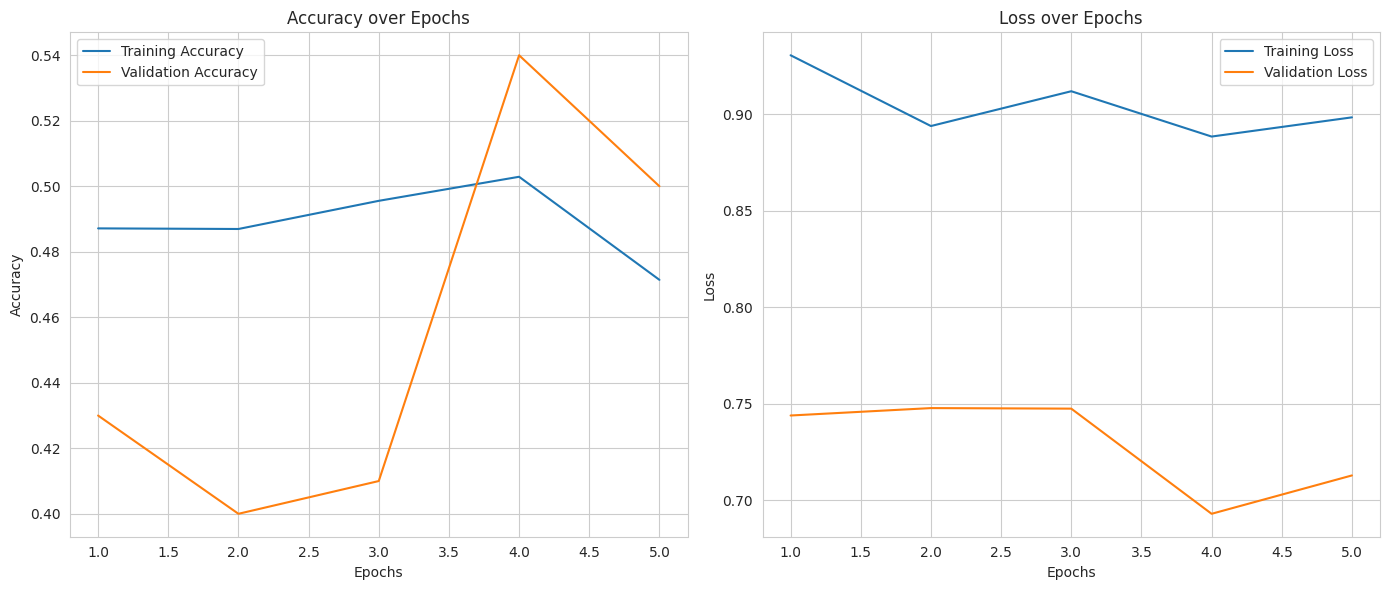

In [42]:
import matplotlib.pyplot as plt

def plot_metrics(history):
    # Extract data with matching lengths
    epochs = range(1, len(history['accuracy']) + 1)
    acc = history.get('accuracy', [])
    val_acc = history.get('val_accuracy', [])
    loss = history.get('loss', [])
    val_loss = history.get('val_loss', [])

    # Truncate metrics to the same length
    min_len = min(len(acc), len(val_acc))
    acc = acc[:min_len]
    val_acc = val_acc[:min_len]

    min_len_loss = min(len(loss), len(val_loss))
    loss = loss[:min_len_loss]
    val_loss = val_loss[:min_len_loss]

    # Plot accuracy
    plt.figure(figsize=(14, 6))
    plt.subplot(1, 2, 1)
    plt.plot(range(1, min_len + 1), acc, label='Training Accuracy')
    plt.plot(range(1, min_len + 1), val_acc, label='Validation Accuracy')
    plt.title('Accuracy over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(range(1, min_len_loss + 1), loss, label='Training Loss')
    plt.plot(range(1, min_len_loss + 1), val_loss, label='Validation Loss')
    plt.title('Loss over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Call the function
plot_metrics(ft_history)


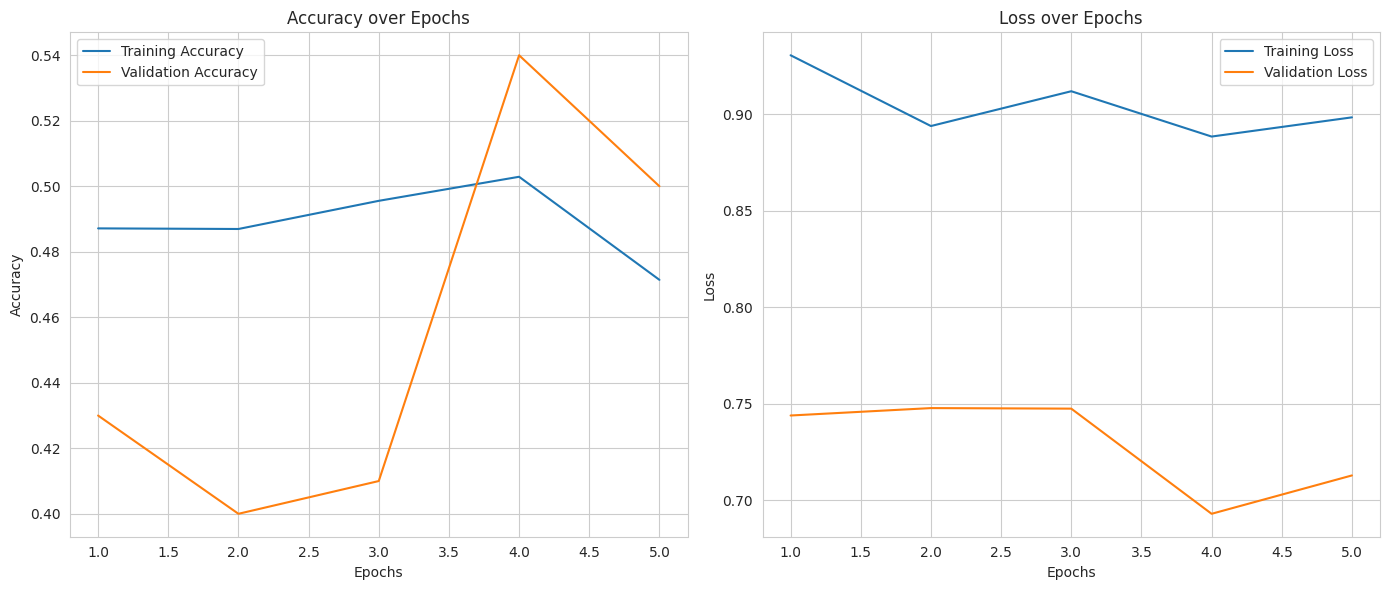

In [43]:
plot_metrics(ft_history)

# Load Model

This line is responsible for loading a previously saved, trained model back into your Python environment so you can use it for making predictions or further analysis

In [44]:
ft_model = load_model(location+'/ft_model.keras') # Change the file extension to .keras

This code is designed to load the training history of a previously trained machine learning model. This history contains information about the model's performance (accuracy, loss, etc.) during its training process.

In [45]:
# Change 'data1a/top_history.txt' to the correct file path.
# Here, we assume that the file is in the 'location' directory.
with open(location + '/top_history.txt') as f:
    top_history = json.load(f)

This code is designed to load the training history of a previously trained machine learning model, specifically the fine-tuning stage, and store it in a variable called ft_history. This history contains valuable information about the model's performance during the training process, which can be used for analysis and visualization.

In [46]:
with open(location + '/ft_history.txt') as f:
    ft_history = json.load(f)

This code defines a function called plot_acc_metrics. Its primary purpose is to create a plot that visually compares the accuracy of a machine learning model during two phases: initial training (hist1) and fine-tuning (hist2). This comparison helps you understand how the model's performance improves after fine-tuning

In [47]:
def plot_acc_metrics(hist1, hist2, stop=50):
    fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(4.25,6))

    axes = axes.flatten()

    # Access 'accuracy' and 'val_accuracy' instead of 'acc' and 'val_acc'
    axes[0].plot(range(stop), hist1['accuracy'], label='Training', color='#FF533D')
    axes[0].plot(range(stop), hist1['val_accuracy'], label='Validation', color='#03507E')
    axes[0].set_title('Training')
    axes[0].set_ylabel('Accuracy')
    axes[0].set_xlabel('Epoch')
    axes[0].legend(loc='lower right')

    axes[1].plot(range(stop), hist2['accuracy'], label='Training', color='#FF533D')
    axes[1].plot(range(stop), hist2['val_accuracy'], label='Validation', color='#03507E')
    axes[1].set_title('Fine-tuning')
    axes[1].set_ylabel('Accuracy')
    axes[1].set_xlabel('Epoch')
    axes[1].legend(loc='lower right')

    plt.tight_layout();

This line of code triggers the creation of a plot that visually compares the accuracy of the model before and after the fine-tuning process, using the training history data stored in the top_history and ft_history variables.

In [49]:
print(len(top_history['accuracy']))
print(len(top_history['val_accuracy']))
print(len(ft_history['accuracy']))
print(len(ft_history['val_accuracy']))


5
5
5
5


In [50]:
print(top_history.keys())
print(ft_history.keys())


dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])
dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])


In [51]:
min_len = min(len(top_history['accuracy']), len(ft_history['accuracy']))
top_acc = top_history['accuracy'][:min_len]
ft_acc = ft_history['accuracy'][:min_len]


In [52]:
min_val_len = min(len(top_history['val_accuracy']), len(ft_history['val_accuracy']))
top_val_acc = top_history['val_accuracy'][:min_val_len]
ft_val_acc = ft_history['val_accuracy'][:min_val_len]


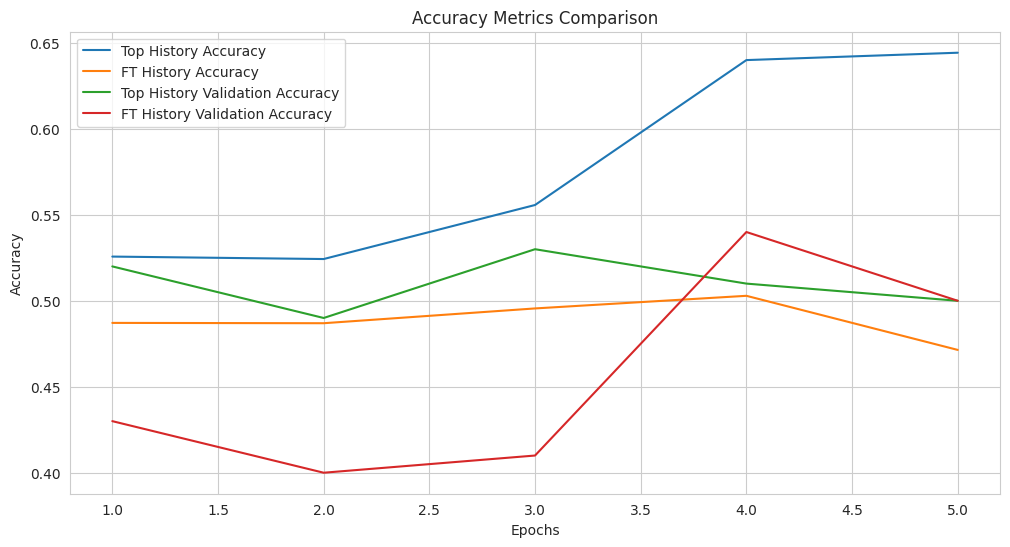

In [53]:
import matplotlib.pyplot as plt

def plot_acc_metrics(top_history, ft_history):
    # Ensure metric lengths match
    min_acc_len = min(len(top_history['accuracy']), len(ft_history['accuracy']))
    top_acc = top_history['accuracy'][:min_acc_len]
    ft_acc = ft_history['accuracy'][:min_acc_len]

    min_val_acc_len = min(len(top_history['val_accuracy']), len(ft_history['val_accuracy']))
    top_val_acc = top_history['val_accuracy'][:min_val_acc_len]
    ft_val_acc = ft_history['val_accuracy'][:min_val_acc_len]

    # Plot the metrics
    epochs = range(1, min_acc_len + 1)
    val_epochs = range(1, min_val_acc_len + 1)

    plt.figure(figsize=(12, 6))
    plt.plot(epochs, top_acc, label='Top History Accuracy')
    plt.plot(epochs, ft_acc, label='FT History Accuracy')
    plt.plot(val_epochs, top_val_acc, label='Top History Validation Accuracy')
    plt.plot(val_epochs, ft_val_acc, label='FT History Validation Accuracy')

    plt.title('Accuracy Metrics Comparison')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)
    plt.show()

# Call the function
plot_acc_metrics(top_history, ft_history)


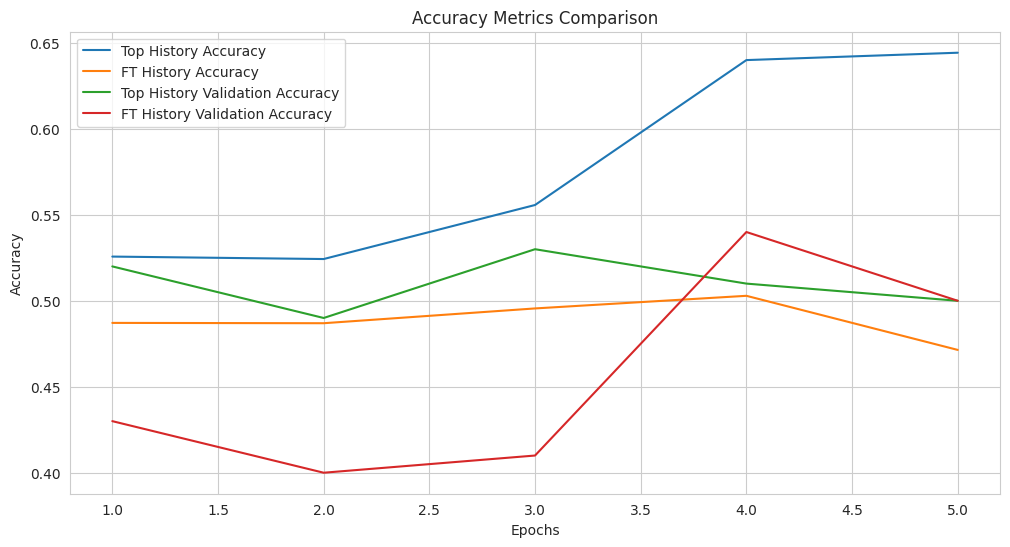

In [54]:
plot_acc_metrics(top_history, ft_history)

This line is creating an array called validation_labels which is used to store the true labels for your validation dataset. This is crucial for evaluating how well your model is performing.

In [55]:
validation_labels = np.array([0] * (nb_validation_samples // 2) + [1] * (nb_validation_samples // 2))

This function, evaluate_binary_model, is designed to assess the performance of a trained binary classification model, likely used for image classification.

In [56]:
def evaluate_binary_model(model, directory, labels):
    datagen = ImageDataGenerator(rescale=1./255)

    generator = datagen.flow_from_directory(directory, target_size=(img_height,img_width), batch_size=batch_size, class_mode='binary', shuffle=False)

    # Replace predict_generator with predict and adjust arguments
    predictions = model.predict(generator, steps=len(labels) // batch_size)

    pred_labels = [0 if i<0.5 else 1 for i in predictions]

    print('')
    print(classification_report(validation_labels, pred_labels))
    print('')
    cm = confusion_matrix(validation_labels, pred_labels)
    return cm

This function, evaluate_binary_model, is designed to evaluate the performance of a trained binary classification model on a set of images.

In [57]:
def evaluate_binary_model(model, directory, labels):
    datagen = ImageDataGenerator(rescale=1./255)

    generator = datagen.flow_from_directory(directory, target_size=(img_height,img_width), batch_size=batch_size, class_mode='binary', shuffle=False)

    # Replace predict_generator with predict and adjust arguments
    predictions = model.predict(generator, steps=len(labels) // batch_size)

    # Compare the first element of the prediction to 0.5
    pred_labels = [0 if i[0] < 0.5 else 1 for i in predictions]

    print('')
    print(classification_report(validation_labels, pred_labels))
    print('')
    cm = confusion_matrix(validation_labels, pred_labels)
    return cm

This line is the culmination of the model evaluation process. It's calling the evaluate_binary_model function to assess the performance of your fine-tuned model (ft_model) and storing the results in a variable called cm.

In [58]:
cm = evaluate_binary_model(ft_model, validation_data_dir, validation_labels)

Found 460 images belonging to 2 classes.
2/2 ━━━━━━━━━━━━━━━━━━━━ 85s 42s/step

              precision    recall  f1-score   support

           0       0.45      0.60      0.52        50
           1       0.41      0.28      0.33        50

    accuracy                           0.44       100
   macro avg       0.43      0.44      0.43       100
weighted avg       0.43      0.44      0.43       100




Imagine you have a heatmap that shows the performance of your image classification model. This line of code is basically defining the labels you want to use for the rows or columns of that heatmap. In this case, those labels are 'Damaged' and 'Whole', which might correspond to the two classes your model is trying to distinguish between (e.g., classifying images of objects as either damaged or whole).

In [59]:
heatmap_laebls = ['Damaged', 'Whole']

These two lines of code work together to generate a heatmap visualization of a confusion matrix (likely representing the results of an image classification model). The heatmap will have 'Damaged' and 'Whole' as labels for its rows and columns, visually showing how the model performed in classifying images into these categories using colored cells and numerical annotations. It uses an orange-to-red color scheme for visual clarity

<Axes: >

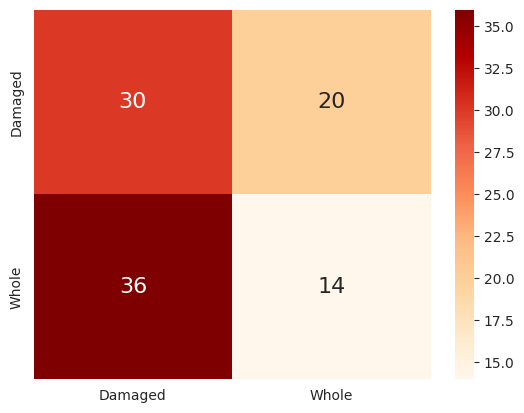

In [60]:
heatmap_labels = ['Damaged', 'Whole']  # Corrected spelling
sns.heatmap(cm, annot=True, annot_kws={"size":16}, fmt='g', cmap='OrRd', xticklabels=heatmap_labels, yticklabels=heatmap_labels)

This line is using the Seaborn library (sns) to create a heatmap visualization of a confusion matrix, which is stored in the variable cm. A confusion matrix is a table that is often used to describe the performance of a classification model.

<Axes: >

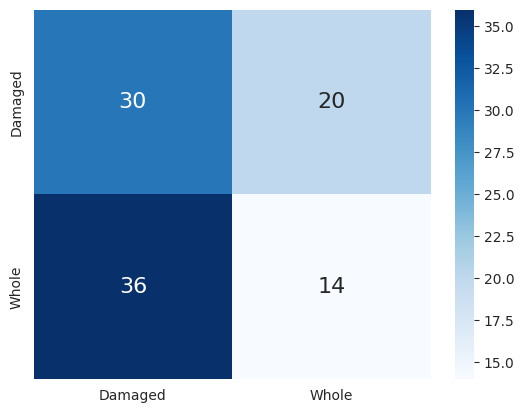

In [61]:
sns.heatmap(cm, annot=True, annot_kws={"size": 16}, fmt='g', cmap='Blues', xticklabels=heatmap_labels, yticklabels=heatmap_labels)

# Path2

 The path2 function takes an image, pre-processes it, uses a trained model to predict if there is damage, and provides feedback to the user based on the prediction.

In [62]:
def path2(image_path, model):
    urllib.request.urlretrieve(image_path, 'save.jpg')
    img = load_img('save.jpg', target_size=(256,256))
    x = img_to_array(img)
    x = x.reshape((1,) + x.shape)/255
    pred = model.predict(x)
    print("Validating that damage exists....")
    print(pred)
    if(pred[0][0]<=0.5):
        print("Validation complete - proceed to location and severity determination")
    else:
        print ("Are you sure that your car is damaged? Please submit another picture of the damage.")
        print ("Hint: Try zooming in/out, using a different angle or different lighting")

This line is using the Image function (likely from the IPython.display module, which was imported earlier in the notebook) to display an image within the Jupyter notebook.

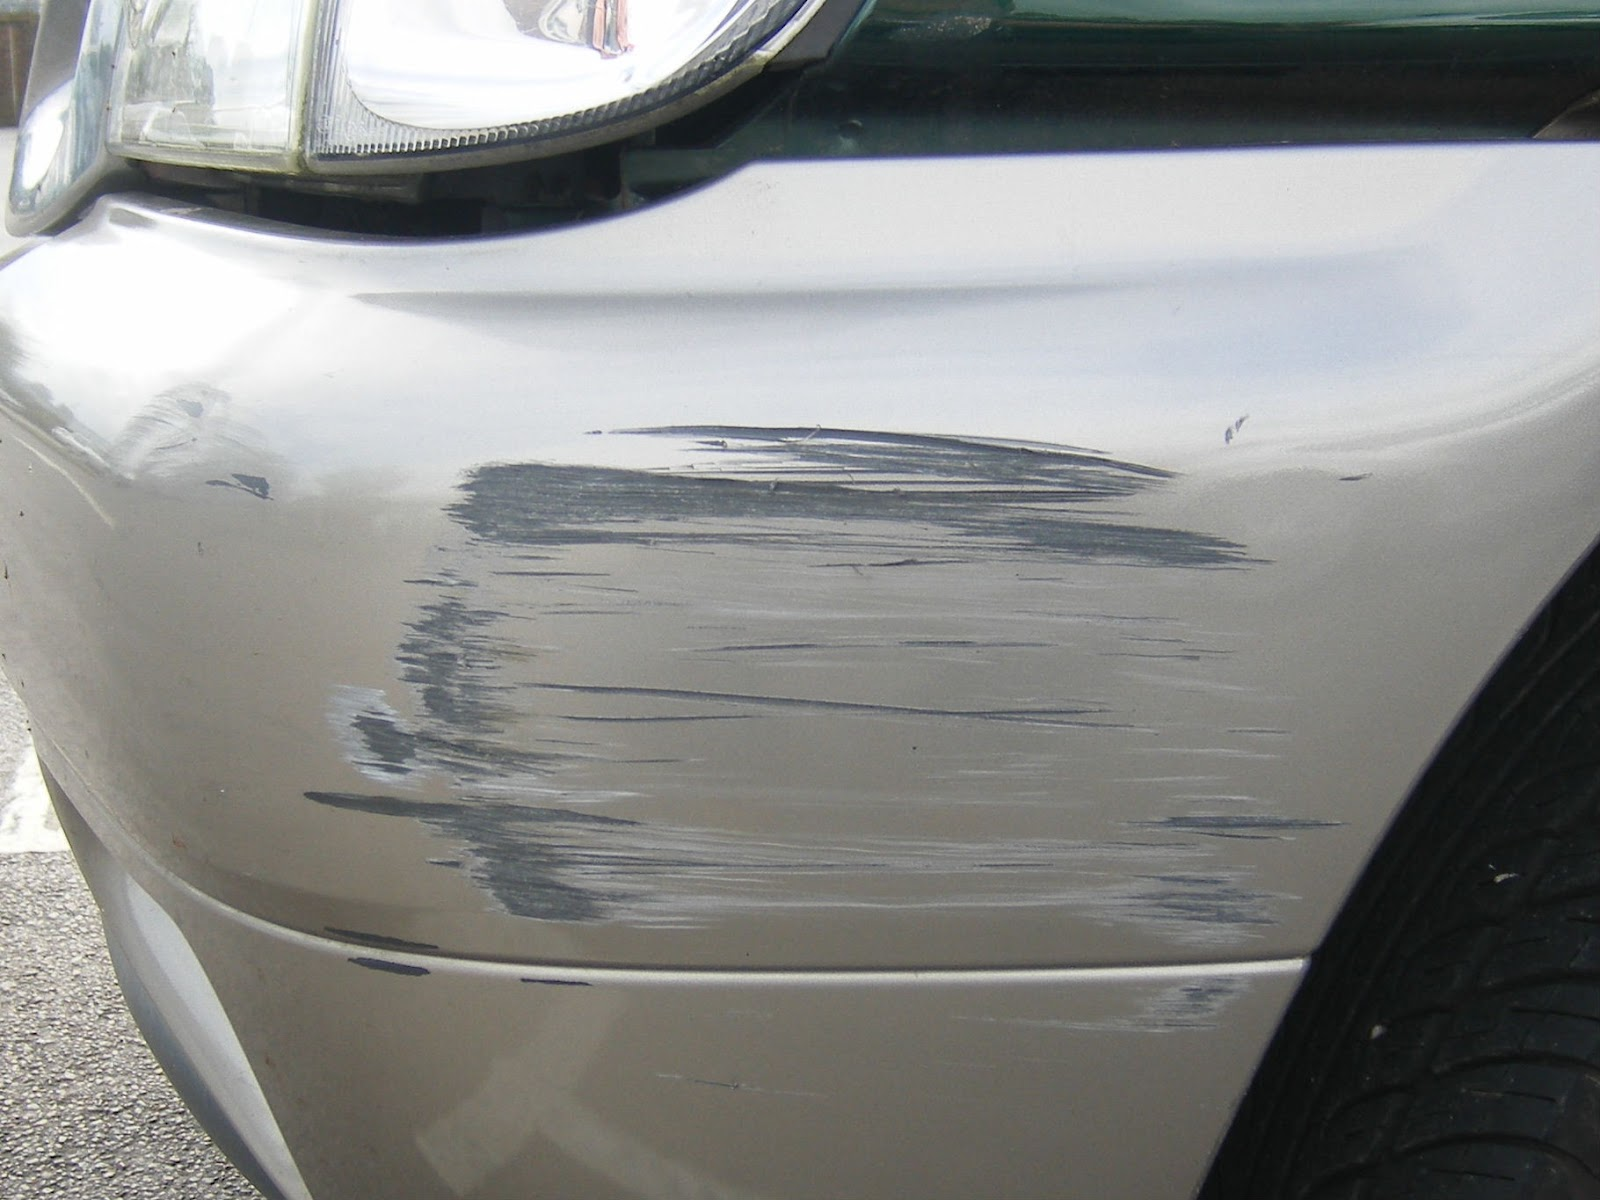

In [63]:
Image('http://3.bp.blogspot.com/-PrRY9XxCqYQ/UDNutnMI7LI/AAAAAAAABdw/UGygghh-hRA/s1600/Bumper+scuff.JPG')

This line is essentially making a prediction on an image using the path2 function and the fine-tuned model ft_model.

In [64]:
path2('http://3.bp.blogspot.com/-PrRY9XxCqYQ/UDNutnMI7LI/AAAAAAAABdw/UGygghh-hRA/s1600/Bumper+scuff.JPG', ft_model)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 884ms/step
Validating that damage exists....
[[0.65500045 0.3449995 ]]
Are you sure that your car is damaged? Please submit another picture of the damage.
Hint: Try zooming in/out, using a different angle or different lighting


This line of code is designed to display an image directly within your Jupyter Notebook.

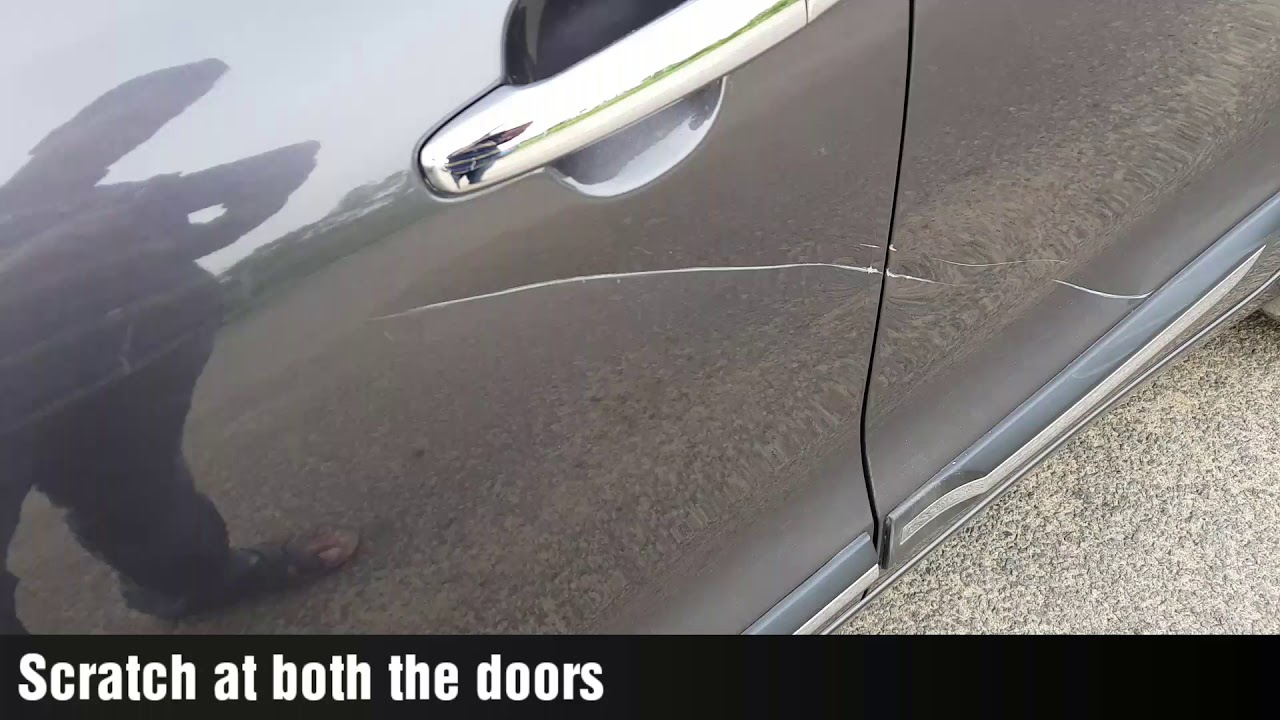

In [65]:
Image('https://i.ytimg.com/vi/4oV1klVPogY/maxresdefault.jpg')

This line is using the path2 function to make a prediction on an image.

In [66]:
path2('https://i.ytimg.com/vi/4oV1klVPogY/maxresdefault.jpg', ft_model)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Validating that damage exists....
[[0.5371319  0.46286803]]
Are you sure that your car is damaged? Please submit another picture of the damage.
Hint: Try zooming in/out, using a different angle or different lighting


In [73]:
def path2(image_path, model):
    # Use load_img directly for local files
    img = load_img(image_path, target_size=(256,256))
    x = img_to_array(img)
    x = x.reshape((1,) + x.shape)/255
    # ... (rest of your path2 function) ...

In [74]:
path2('/content/accident-damage-on-a-car-after-an-accident.jpg', ft_model)

In [76]:
def path3(image_path, model):
    urllib.request.urlretrieve(image_path, 'save.jpg')
    img = load_img('save.jpg', target_size=(256,256))
    x = img_to_array(img)
    x = x.reshape((1,) + x.shape)/255
    pred = model.predict(x)
    print("Validating that damage exists....")
    print(pred)
    if(pred[0][0]<=0.5):
        print("Validation complete - proceed to location and severity determination")
    else:
        print ("Are you sure that your car is damaged? Please submit another picture of the damage.")
        print ("Hint: Try zooming in/out, using a different angle or different lighting")

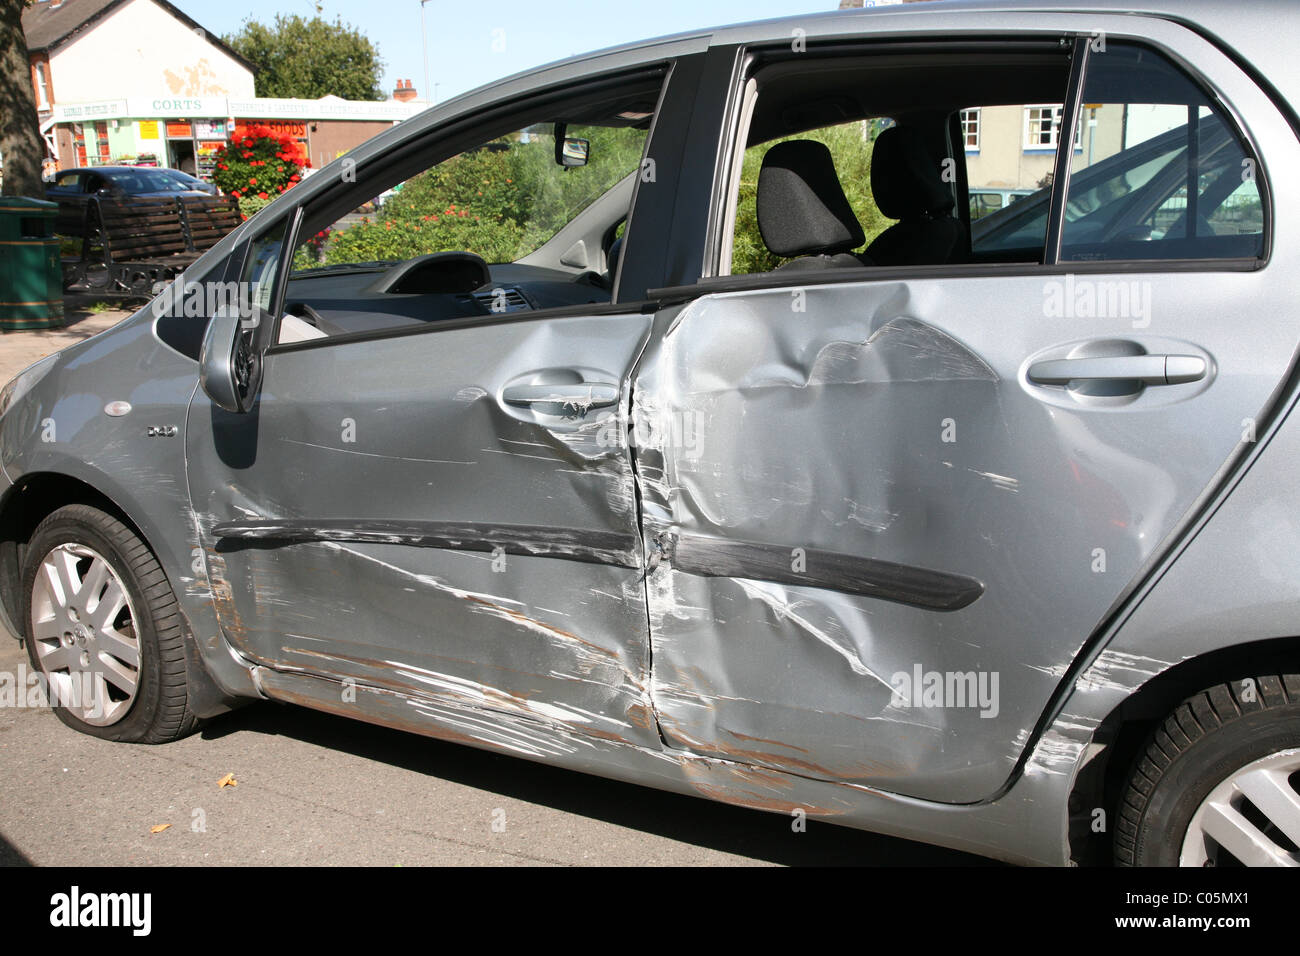

In [77]:
Image('/content/accident-damage-on-a-car-after-an-accident.jpg')

In [82]:
import os
print(os.getcwd())  # Print current working directory


/content


In [83]:
from google.colab import files
uploaded = files.upload()


Saving accident-damage-on-a-car-after-an-accident.jpg to accident-damage-on-a-car-after-an-accident (1).jpg


In [86]:
print(ft_model.input_shape)


(None, 256, 256, 3)


In [87]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import numpy as np

def path3(image_path, model):
    """
    Predict damage for a given car image.

    Args:
        image_path (str): Path to the image.
        model (tf.keras.Model): Trained model for damage prediction.

    Returns:
        str: Predicted damage class.
    """
    # Load and preprocess the image
    target_size = (224, 224)  # Adjust based on model.input_shape
    img = load_img(image_path, target_size=target_size)
    img_array = img_to_array(img) / 255.0  # Normalize pixel values
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension

    # Make predictions
    predictions = model.predict(img_array)
    predicted_class = np.argmax(predictions, axis=1)[0]

    return predicted_class


In [88]:
ft_model.summary()


Model: "functional_16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)           │ (None, 256, 256, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 256, 256, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 256, 256, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 128, 128, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 128, 128, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 128, 128, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 64, 64, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 64, 64, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 64, 64, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 64, 64, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 32, 32, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 32, 32, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 32, 32, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 32, 32, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 16, 16, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 16, 16, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 16, 16, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 16, 16, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 8, 8, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential_3 (Sequential)            │ (None, 2)                   │       8,389,378 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 23,104,068 (88.14 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 23,104,066 (88.14 MB)

 Optimizer params: 2 (12.00 B)

In [91]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import numpy as np

def path3(image_path, model):
    """
    Predict damage for a given car image.

    Args:
        image_path (str): Path to the image.
        model (tf.keras.Model): Trained model for damage prediction.

    Returns:
        str: Predicted damage class.
    """
    # Load and preprocess the image with the correct target size
    target_size = (256, 256)  # Adjust based on model.input_shape
    img = load_img(image_path, target_size=target_size)
    img_array = img_to_array(img) / 255.0  # Normalize pixel values
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension

    # Make predictions
    predictions = model.predict(img_array)
    predicted_class = np.argmax(predictions, axis=1)[0]

    return predicted_class


In [92]:
predicted_damage = path3('/content/accident-damage-on-a-car-after-an-accident.jpg', ft_model)
print(f"Predicted Damage Class: {predicted_damage}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 946ms/step
Predicted Damage Class: 14
